# Finding blobs in 64x64 images using conv2d

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random

In [2]:
data='/media/smc/Blobs/'

# Get data

Data reading function

In [3]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

Read in blobs tiff

In [4]:
all_dataA=read_tiff(data+'CountBlobsEasy.tif',10000)
all_dataB=read_tiff(data+'CountBlobsEasier.tif',10000)
all_dataC=read_tiff(data+'CountBlobs.tif',10000)

In [5]:
dfA=pd.read_csv(data+'CountBlobsEasyTruth.csv')
dfB=pd.read_csv(data+'CountBlobsEasierTruth.csv')
dfC=pd.read_csv(data+'CountBlobsTruth.csv')

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [6]:
def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    #out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
    out_layer=tf.contrib.layers.conv2d(input_data, num_filters, filter_shape)

    # add the bias
    #out_layer += bias

    # apply a ReLU non-linear activation
    #out_layer = tf.nn.relu(out_layer)

    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='SAME')

    return out_layer

In [7]:
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64])
y=tf.placeholder(dtype=tf.float32, shape=[None, 1])

x_shaped=tf.reshape(x, [-1, 64,64,1])
conv1layer=create_new_conv_layer(x_shaped, 1, 32, [5, 5], [2, 2], name='layer1')
conv2layer=create_new_conv_layer(conv1layer, 32, 64, [5, 5], [2, 2], name='layer2')
conv3layer=create_new_conv_layer(conv2layer, 64, 128, [5, 5], [2, 2], name='layer3')

flattened=tf.reshape(conv3layer, [-1,128*8*8 ])
dense1=tf.contrib.layers.fully_connected(flattened,1024)
dense2=tf.contrib.layers.fully_connected(dense1,128)
dense3=tf.contrib.layers.fully_connected(dense2,16)
logits=tf.contrib.layers.fully_connected(dense3,1)

diff=tf.subtract(logits, y)
LS=tf.multiply(diff,diff)
#Add them together
loss=tf.reduce_mean(LS)
train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

# Training on easy set

In [8]:
all_data=all_dataA/300.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [9]:
df=dfA

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [10]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  26.5445
Error rate:  (100, 1)
Real loss:  0.153005
Error rate:  (100, 1)
Real loss:  0.0542201
Error rate:  (100, 1)
Real loss:  0.0760737


KeyboardInterrupt: 

In [11]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

<IPython.core.display.Javascript object>


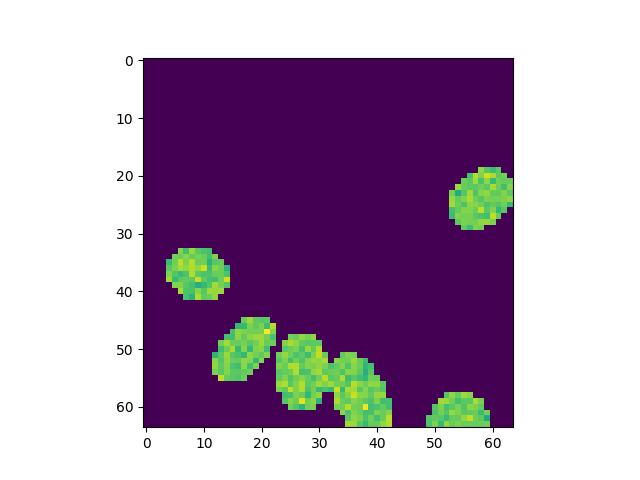

168
6
5.89401
11.4224105204


In [12]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(rid)
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])*105)

# Training on middle set

In [194]:
all_data=all_dataB/400.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [195]:
df=dfB

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [196]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  25.428
Error rate:  (100, 1)
Real loss:  0.256215
Error rate:  (100, 1)
Real loss:  0.117683
Error rate:  (100, 1)
Real loss:  0.0558641
Error rate:  (100, 1)
Real loss:  0.0297616
Error rate:  (100, 1)
Real loss:  0.0196591
Error rate:  (100, 1)
Real loss:  0.0181155


In [197]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

<IPython.core.display.Javascript object>


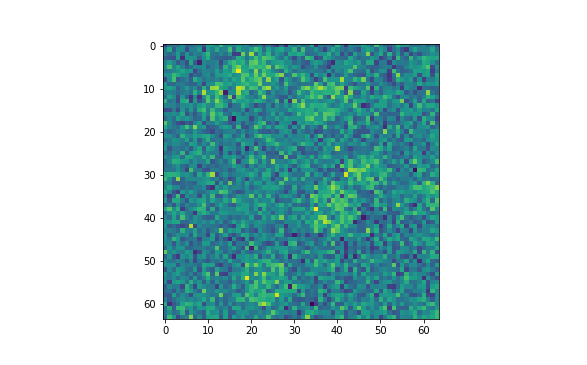

5
4.93529
0.0110632047224


In [198]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Training on final set

In [13]:
all_data=all_dataC/500.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [14]:
df=dfC

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [15]:
for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  1172.87
Error rate:  (100, 1)
Real loss:  0.714915
Error rate:  (100, 1)
Real loss:  0.391885
Error rate:  (100, 1)
Real loss:  0.239278
Error rate:  (100, 1)
Real loss:  0.187926
Error rate:  (100, 1)
Real loss:  0.171051


KeyboardInterrupt: 

In [16]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})
losses

0.23050563

<IPython.core.display.Javascript object>


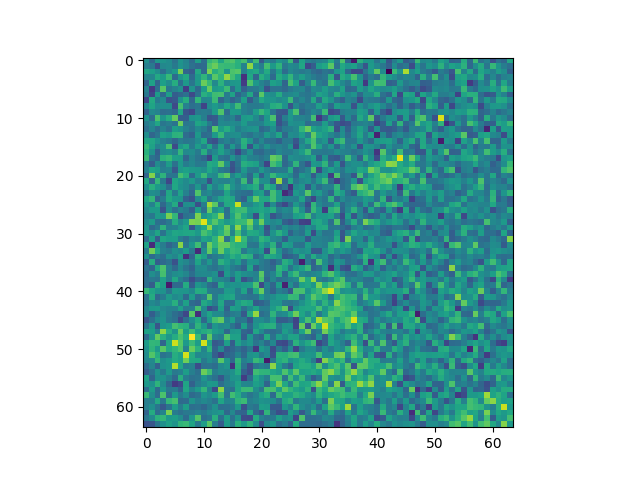

8
7.08116
0.0120605771874


In [28]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Compare to simple mean

In [225]:
validation_truth.shape

(1999, 1)

<IPython.core.display.Javascript object>


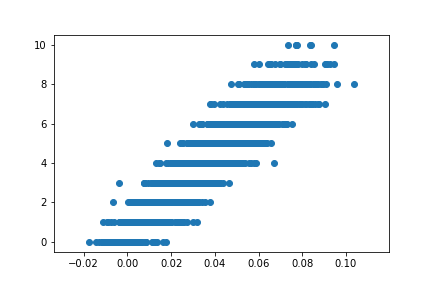

In [205]:
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

263
29
24
263
85
77


<IPython.core.display.Javascript object>


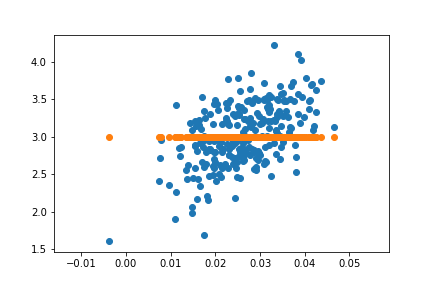

In [227]:
tmp=validation_truth[:,0]==3
subval=validation_data[tmp,:,:]
subtruth=validation_truth[tmp,0]
subresults=results[tmp,0]

print(np.sum(subresults>-3.5))
print(np.sum(subresults>3.5))
print(np.sum(subresults<2.5))

print(np.sum(np.mean(subval, axis=(1,2))>-3.5))
print(np.sum(np.mean(subval, axis=(1,2))>.0305))
print(np.sum(np.mean(subval, axis=(1,2))<.0215))

plt.scatter(np.mean(subval, axis=(1,2)), subresults[:])
plt.scatter(np.mean(subval, axis=(1,2)), subtruth[:])

<IPython.core.display.Javascript object>


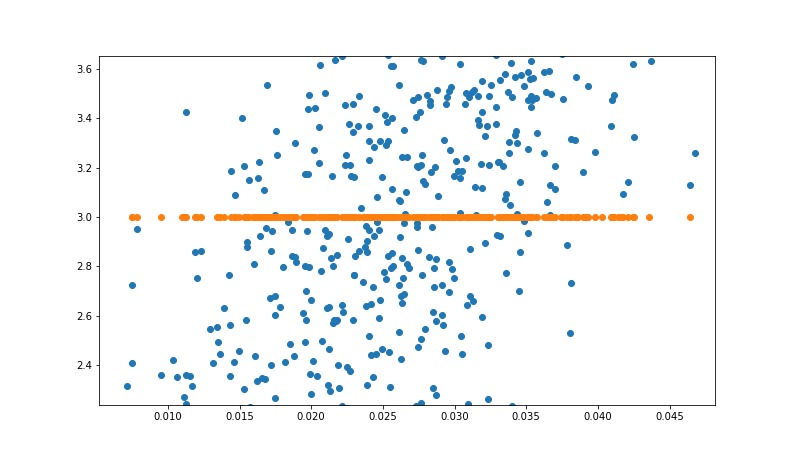

In [224]:
plt.scatter(np.mean(validation_data, axis=(1,2)), results[:,0])
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

(array([[  98.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   2.,  209.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    9.,  215.,   10.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,   12.,  195.,   20.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,   27.,  192.,   34.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,   34.,  214.,   37.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    3.,   46.,  206.,   40.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    3.,   56.,  146.,   21.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    7.,   38.,   69.,
            9.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,   15.,
           28.]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 array([  0.,   1.,   2.,   3., 

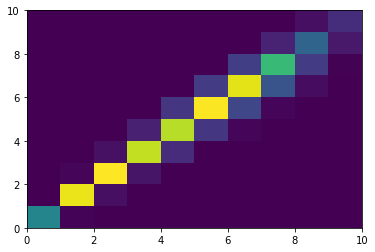

In [232]:
plt.hist2d(validation_truth[:,0], np.round(results[:,0]))

# Look at filters

In [29]:
results, LN,losses,c1,c2,c3,d1,d2,d3=sess.run([logits, LS, loss, conv1layer, conv2layer, conv3layer, dense1, dense2, dense3], feed_dict={x:validation_data, y:validation_truth})

In [143]:
c1.shape

(1999, 32, 32, 32)

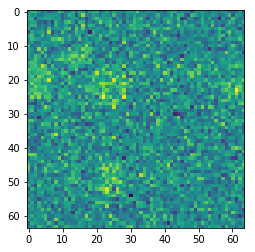

In [34]:
plt.imshow(validation_data[4,:,:])

In [37]:
results[4]

array([ 5.44568968], dtype=float32)

/home/smc/anaconda3/envs/tflow/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


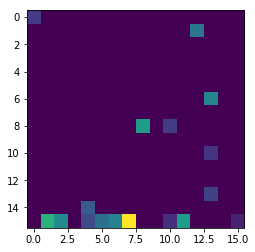

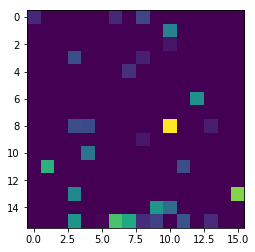

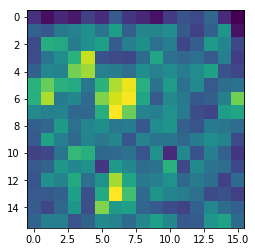

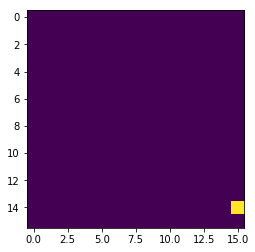

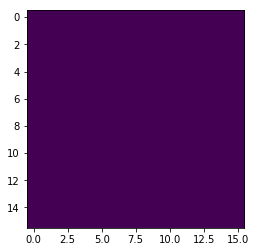

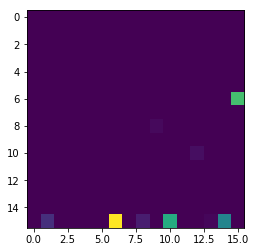

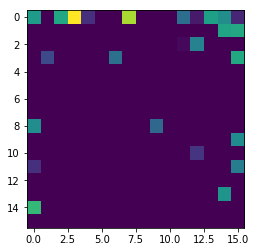

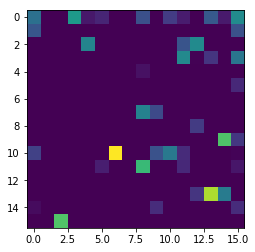

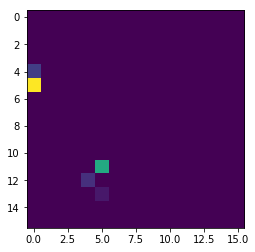

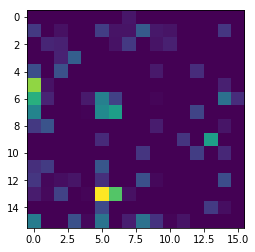

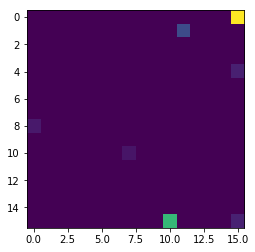

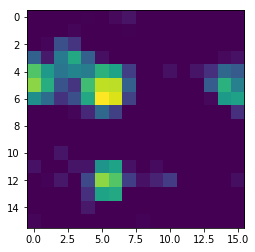

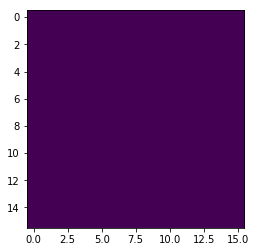

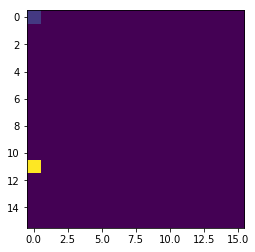

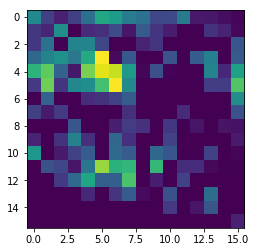

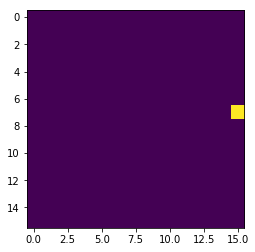

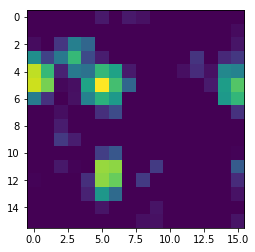

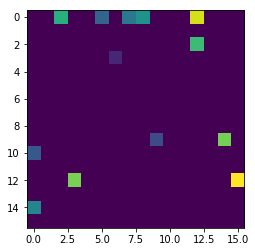

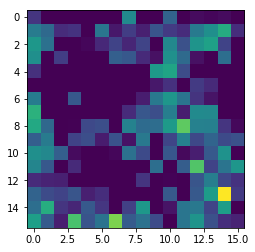

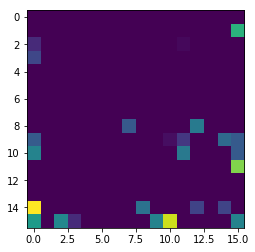

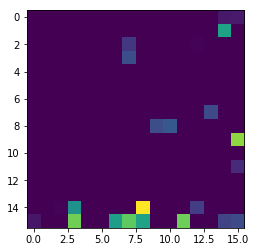

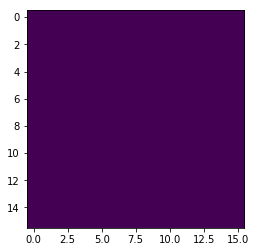

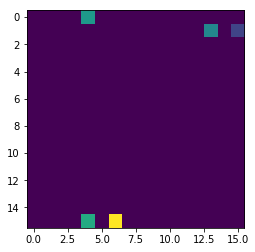

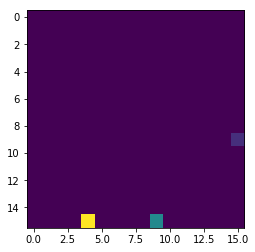

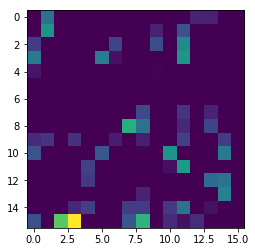

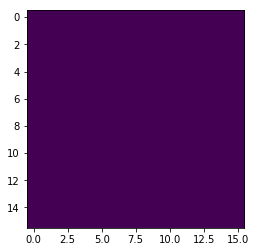

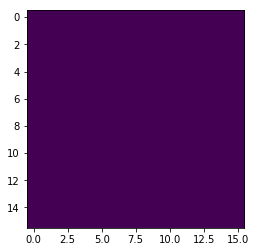

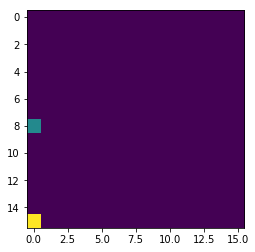

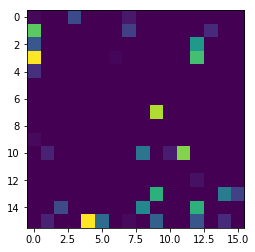

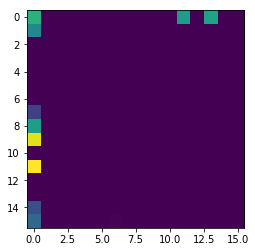

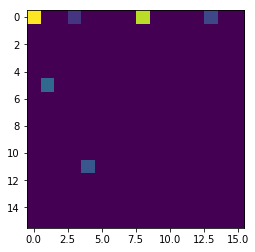

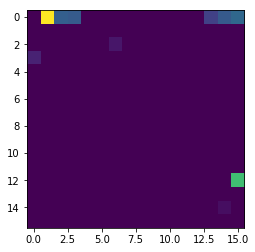

In [36]:
idx=4
for i in range(0,c1.shape[3]):
    plt.figure()
    plt.imshow(c2[idx,:,:,i])

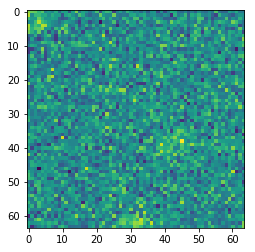

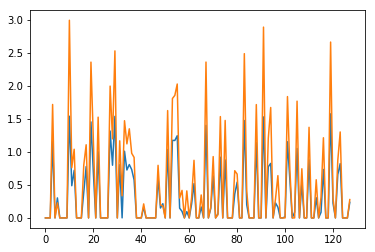

In [173]:
idx=1
plt.imshow(validation_data[idx,:,:])
plt.figure()
plt.plot(range(0,128),d2[idx,:],range(0,128),d2[4,:])

In [158]:
d3.shape

(1999, 16)